In [1]:
# # 코랩이나 캐글을 사용한다면 이 셀의 주석을 제거하고 실행하세요.
# !git clone https://github.com/rickiepark/nlp-with-transformers.git
# %cd nlp-with-transformers
# from install import *
# install_requirements(chapter=8)

# 효율적인 트랜스포머 구축

1. 지식 정제로 모델 크기 줄이기
2. 옵투나로 좋은 하이퍼파라미터 찾기
3. 양자화로 모델 속도 높이기
4. ONNX와 ONNX 런타임으로 추론 최적화하기
5. 가중치 가지치기

<img alt="Scaling BERT at Roblox" caption="How Roblox scaled BERT with knowledge distillation, dynamic padding, and weight quantization (photo courtesy of Roblox employees Quoc N. Le and Kip Kaehler)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_roblox.png?raw=1" id="roblox"/>

## 의도 탐지 예제

<img alt="Out of Scope Query" width="400" caption="Three exchanges between a human (right) and a text-based assistant (left) for personal finance (courtesy of Stefan Larson et al.)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_oos.png?raw=1" id="oos"/>

In [2]:
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc" # bert_ckpt 변수에 사전 학습된 모델 체크포인트 이름을 할당,  bert-base-uncased 모델을 fine-tuned한 버전
pipe = pipeline("text-classification", model=bert_ckpt) # 임상 텍스트 분류 데이터 세트, 텍스트 분류 파이프라인을 생성

In [4]:
''' 쿼리에 대한 응답 '''
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in
Paris and I need a 15 passenger van"""
pipe(query)
# label은 예측된 클래스 레이블을 나타내고, score는 해당 레이블에 대한 확률 점수를 나타냄

[{'label': 'car_rental', 'score': 0.5490031242370605}]

## 벤치마크 클래스 만들기
- 추후 개선사항 결과비교를 위한 Class

In [5]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type

    def compute_accuracy(self):
        # 나중에 정의합니다
        pass

    def compute_size(self):
        # 나중에 정의합니다
        pass

    def time_pipeline(self):
        # 나중에 정의합니다
        pass

    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size() # 파이프라인의 크기 또는 메모리 사용량을 측정
        metrics[self.optim_type].update(self.time_pipeline()) # 파이프라인의 실행 시간을 측정
        metrics[self.optim_type].update(self.compute_accuracy()) # 데이터 세트에서 정확도를 계산
        return metrics

본 과제에서 사용할 데이터 셋

In [6]:
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus") # "clinc_oos" 데이터 셋을 "plus" 구성으로 로드
# "clinc_oos" : 대화형 AI 시스템에서 사용되는 임상 관련 데이트셋, Plus는 특정 버전전
sample = clinc["test"][42]
print(sample)

In [8]:
intents = clinc["test"].features["intent"]

intents.int2str(sample["intent"]) # sample의 레이블

'transfer'

평가 지표

In [9]:
import evaluate # 다양한 자연어 처리 모델 평가 지표를 계산하는 데 사용되는 라이브러리

accuracy_score = evaluate.load("accuracy") # accuracy 평가 지표를 로드

In [10]:
''' compute_accuracy 정의 '''

def compute_accuracy(self):
    """PerformanceBenchmark.compute_accuracy() 메서드를 오버라이드합니다"""
    preds, labels = [], []
    for example in self.dataset: # set에 있는 각 예제에 대해 예측값과 실제값을 수집
        pred = self.pipeline(example["text"])[0]["label"] # 텍스트를 분석하고 예측값을 얻음
        label = example["intent"]

        # 예측값을 실제값과 비교하여 preds와 labels 리스트에 추가
        preds.append(intents.str2int(pred))
        labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"테스트 세트 정확도 - {accuracy['accuracy']:.3f}")
    return accuracy

PerformanceBenchmark.compute_accuracy = compute_accuracy # PerformanceBenchmark 클래스에 compute_accuracy 메서드를 추가

In [11]:
list(pipe.model.state_dict().items())[42] # 키(파라미터 이름)-값(파라미터의 ) 쌍의 튜플

('bert.encoder.layer.2.attention.self.value.bias',
 tensor([-2.7834e-02,  4.9434e-02,  8.3551e-02,  4.1092e-02,  6.0157e-01,
          1.1774e-01, -5.2112e-02, -6.5143e-02, -2.9358e-02, -4.2250e-02,
          7.9177e-02,  8.0409e-02,  2.9921e-03,  1.7816e-01, -5.0480e-02,
         -1.5634e-01, -2.1707e-02,  1.4381e-02,  2.5132e-02, -2.4110e-02,
         -1.9183e-01, -7.8657e-02,  5.0709e-02,  3.3632e-02, -3.1946e-02,
          1.1616e-01,  9.2720e-02, -1.1787e-01,  2.3233e-01, -1.2678e-02,
         -1.3138e-01, -4.0024e-02,  7.4823e-02, -5.4148e-02, -1.5184e-01,
         -7.4407e-02,  1.1559e-01,  8.2729e-02, -1.3787e-01,  8.3528e-02,
          1.2154e-01,  1.6880e-02, -5.6629e-02, -3.9295e-02,  5.3725e-02,
          6.8602e-02, -1.1294e-01,  4.4001e-02, -2.5884e-01,  1.6767e-01,
          1.8316e-01,  5.6272e-02, -3.6874e-02, -2.7938e-02, -9.3204e-02,
         -7.5239e-03,  4.1141e-02, -1.1542e-02, -9.9749e-02, -3.0910e-02,
          4.1398e-02, -4.4389e-02, -2.6279e-02,  7.2100e-02, 

In [12]:
import torch
from pathlib import Path

def compute_size(self):
    state_dict = self.pipeline.model.state_dict() # 파이프라인의 모델 상태 사전을 가져옴
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)
    
    ''' 저장된 파일의 크기를 바이트 단위로 읽어와 메가바이트 단위로 변환하여 계산 '''
    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024) 
    
    tmp_path.unlink() # 임시 파일을 삭제
    print(f"모델 크기 (MB) - {size_mb:.2f}")
    return {"size_mb": size_mb}

PerformanceBenchmark.compute_size = compute_size

In [13]:
''' 파이프라인을 사용하여 쿼리를 처리하고 레이턴시(응답 시간)를 측정하는 루프를 구현 '''

from time import perf_counter

for _ in range(3):
    start_time = perf_counter()
    _ = pipe(query) # 파이프라인으로 쿼리 처리함, 반환된 결과는 사용하지 않으므로 _ 변수에 할당
    latency = perf_counter() - start_time
    print(f"레이턴시 (ms) - {1000 * latency:.3f}")

레이턴시 (ms) - 113.026
레이턴시 (ms) - 120.041
레이턴시 (ms) - 98.718


In [14]:
''' 주어진 쿼리를 사용하여 파이프라인의 처리 시간 측정 '''

import numpy as np

def time_pipeline(self, query="What is the pin number for my account?"):
    latencies = []
    # 워밍업
    for _ in range(10): # 초기 실행의 영향을 제거하기 위함함
        _ = self.pipeline(query) 
    # 실행 측정
    for _ in range(100): # 주어진 횟수만큼 파이프라인을 실행/시간 측정
        start_time = perf_counter()
        _ = self.pipeline(query)
        latency = perf_counter() - start_time
        latencies.append(latency)
    
    ''' 레이턴시에 대한 통게 계산 '''
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"평균 레이턴시 (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

PerformanceBenchmark.time_pipeline = time_pipeline

In [15]:
pb = PerformanceBenchmark(pipe, clinc["test"]) # PerformanceBenchmark 클래스의 인스턴스를 생성
perf_metrics = pb.run_benchmark() # 파이프라인을 사용하여 데이터셋의 테스트 부분을 평가하고, 평가 결과로써 성능 지표를 반환함

모델 크기 (MB) - 418.15
평균 레이턴시 (ms) - 39.45 +\- 2.39
테스트 세트 정확도 - 0.867


## 지식 정제로 모델 크기 줄이기

- 지식 증류는 큰 모델(Teacher Network)로부터 증류한 지식을 작은 모델(Student Network)로 transfer하는 일련의 과정
------------------------------------------------------------------------------------------------------------------------
- 복잡한 모델 T : 예측 정확도 99% + 예측 소요 시간 3시간
- 단순한 모델 S : 예측 정확도 90% + 예측 소요 시간 3분

지식 증류는 더 크고 복잡한 모델(교사)의 지식을 더 작고 단순한 모델(학생)로 전달하는 데 사용되는 기술
한 모델에서 다른 모델로 지식을 추출하기 위해 특정 작업에 대해 사전에 훈련된 교사 모델을 선택하고, 무작위로 초기화된 학생 모델의 출력과 교사의 출력 간의 차이가 최소화되도록 훈련함

https://baeseongsu.github.io/posts/knowledge-distillation/

http://dmqm.korea.ac.kr/activity/seminar/304

# 순서

1. 사전학습모델 구축

2. 학습 방향(손실 정의) 설정
(class) 지식 증류 손실의가중치, 소프트맥스 온도 설정 반영 함수
(class)  ↳ 손실함수 계산 함수 (로짓)
(class) 정확도 계산 함수

3. 지식증류 방식 설정

4. 티처 모델 파인튜닝
5. 스튜던트 모델 초기화
6. 티처모델로부터 스튜던트 모델 학습

### 미세 튜닝을 위한 지식 정제

<img alt="Soft Probabilities" caption="Comparison of a hard label that is one-hot encoded (left), softmax probabilities (middle), and softened class probabilities (right)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_soft-probs.png?raw=1" id="soft-probs"/>

<img alt="Knowledge distillation" caption="The knowledge distillation process" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_kd.png?raw=1" id="kd"/>

### 사전 훈련을 위한 지식 정제

### 지식 정제 트레이너 만들기

In [16]:
from transformers import TrainingArguments
# TrainingArguments : 모델 학습에 필요한 다양한 하이퍼파라미터를 설정 및 관리하는 데 사용

class DistillationTrainingArguments(TrainingArguments):              # 모델 훈련 시 사용되는 인자들을 설정하는 목적
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs): # 초기화
        super().__init__(*args, **kwargs)
        self.alpha = alpha             # 지식 증류 손실의 가중치
        self.temperature = temperature # 지식 증류 시 사용되는 소프트맥스 온도

In [17]:
'''  지식 증류(Knowledge Distillation)를 사용하는 모델 훈련 '''

import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainer(Trainer): # Trainer 클래스를 상속받아 지식 증류 기능을 추가
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False): # 모델의 손실을 계산하는 함수
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inputs = inputs.to(device)
        outputs_stu = model(**inputs) # inputs을 받아서 스튜던트 모델의 출력을 계산

        # 스튜던트
        loss_ce = outputs_stu.loss # 스튜던트 모델의 크로스 엔트로피 손실 추출
        logits_stu = outputs_stu.logits # 스튜던트 모델의 로짓 추출

        # 티처
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits # 티처의 로짓 추출
 
        # F.log_softmax와 F.softmax 함수를 사용하여 확률을 부드럽게 하고, 정제 손실을 계산
        loss_fct = nn.KLDivLoss(reduction="batchmean") # nn.KLDivLoss 함수를 사용하여 정제 손실 loss_kd를 계산
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))
        
        # 가중 평균된 스튜던트 손실을 반환합니다
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd # args.alpha 매개변수를 사용하여 크로스 엔트로피 손실과 정제 손실을 가중 평균을 도출
        return (loss, outputs_stu) if return_outputs else loss # 최종 손실 반환

### 좋은 스튜던트 초기화 선택하기

In [18]:
from transformers import AutoTokenizer

''' 변수 선언 '''
student_ckpt = "distilbert-base-uncased" 
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt) # 스튜던트 모델용 토크나이저 생성

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True) # "text" 키에 해당하는 텍스트를 토큰으로 변환

# truncation=True: 텍스트 길이가 너무 길 경우 자르도록 설정

''' 데이터 전처리 '''
clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"]) 
# clinc 데이터셋에 tokenize_text 함수를 적용
# remove_columns=["text"] : tokenize_text 함수가 반환한 결과에서 "text" 열을 제거합니다. (텍스트 원본은 더 이상 필요하지 않음)


clinc_enc = clinc_enc.rename_column("intent", "labels") # 열이름 변경

In [19]:
# pip install ipywidgets
# pip install huggingface-cli
# huggingface-cli login

In [20]:
''' 정확도 계산 함수 '''
# 함수 결과 : 튜플 형태이며, 두개의 값이 도출됨  예측 확률 ( logits ), 실제 레이블 ( labels )

def compute_metrics(pred): 
    predictions, labels = pred # 예측값과 실제 레이블 추출
    predictions = np.argmax(predictions, axis=1) # predictions값 중 가장 높은 확률 값의 인덱스 도출
    return accuracy_score.compute(predictions=predictions, references=labels) # 정확도 계산 (일치하는 데이터 개수를 전체 데이터 개수로 나누어 정확도 계산)

In [25]:
'''  지식 증류 방식으로 모델을 미세 조정하는 과정을 설정 '''

batch_size = 48
finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc" # 미세 조정된 모델을 저장할 디렉토리 이름

'''  모델 학습에 필요한 인자들 설정 '''
student_training_args = DistillationTrainingArguments(
    output_dir=finetuned_ckpt, evaluation_strategy = "epoch",
    num_train_epochs=5, learning_rate=2e-5, 
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, alpha=1, weight_decay=0.01, # alpha : 손실 가중치, weight_decay : 가중치 감소율
    push_to_hub=True) # 학습 완료 후 모델을 Hugging Face Hub에 저장 여부

In [94]:
''' 학습 과정에서 어떤 동작이 이루어지는지 정의 '''

# 학습 로그가 출력될 빈도를 설정
student_training_args.logging_steps = len(clinc_enc['train']) // batch_size 

student_training_args.disable_tqdm = False

student_training_args.save_steps = 1e9 # 모델 체크포인트가 저장될 빈도를 설정

# 트랜스포머 4.23.0 버전부터 로깅 수준을 문자열로 지정해야 합니다.
# student_training_args.log_level = 40

student_training_args.log_level = 'error'
# 학습 로그 레벨을 설정, 여기서는 'error'로 설정되어 있어 에러 메시지만 로깅됨

In [95]:
%env TOKENIZERS_PARALLELISM=false # 토크나이저 병렬 처리 비활성화

# 일반적으로 토크나이저는 병렬 처리를 사용하여 여러 문장을 동시에 토큰화하여 처리합니다. 
# 이는 처리 속도를 향상시킬 수 있는 방법 중 하나입니다. 
# 그러나 모든 환경에서 병렬 처리가 항상 효율적이지는 않습니다. 
# 특히 작은 크기의 문장이나 처리할 데이터 양이 적을 때는 병렬 처리의 오버헤드가 발생할 수 있습니다. 

env: TOKENIZERS_PARALLELISM=false # 토크나이저 병렬 처리 비활성화


In [28]:
''' 사전 훈련된 파이프라인에서 레이블 정보를 추출 '''

# id2label: 모델의 configuration에 저장된 레이블 ID와 레이블 이름 간의 매핑 정보를 추출 (ID로 레이블 이름 찾기)
# label2id: 레이블 이름과 ID 간의 매핑 정보를 할당 (레이블 이름으로 ID 찾기)

id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

In [29]:
''' 학습 가능한 레이블 수 설정 및 사전 훈련된 모델 재구성 '''
# 기존 사전 훈련된 모델의 configuration을 수정하여 
# 특정 작업에 맞게 학습 가능한 레이블 수를 설정하고, 레이블 매핑 정보를 반영함
# 이렇게 수정된 configuration은 이후 fine-tuning 과정에서 사용될 예정

from transformers import AutoConfig

num_labels = intents.num_classes # configuration을 수정하여 학습 가능한 레이블 수를 num_labels 값으로 설정(최종 출력층 크기)
student_config = (AutoConfig
                  .from_pretrained(student_ckpt, num_labels=num_labels,
                                   id2label=id2label, label2id=label2id)) # 레이블 매핑 정보 (id2label과 label2id)를 반영함, 이 정보는 모델의 예측 결과 해석에 활용 예정

In [30]:
''' Sequence Classification (시퀀스 분류) 모델을 초기화 '''
# 사전 훈련된 Sequence Classification 모델을 로드하고, 
# 수정한 configuration을 적용하여 초기화된 모델을 반환하는 함수를 정의

import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
    return (AutoModelForSequenceClassification
            .from_pretrained(student_ckpt, config=student_config).to(device))

In [31]:
''' 지식 증류 방식을 활용한 Fine-tuning 과정 '''

teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
                 .from_pretrained(teacher_ckpt, num_labels=num_labels)
                 .to(device))

In [32]:
''' DistillationTrainer를 사용하여 teacher 모델로부터 지식을 효과적으로 전달받아 작은 모델을 학습 '''

distilbert_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer) 

# 작은 모델을 학습시키는 Trainer 객체를 생성

distilbert_trainer.train() # 작은 모델(student)을 Fine-tuning

  0%|          | 0/1590 [00:00<?, ?it/s]

{'loss': 4.3233, 'learning_rate': 1.6012578616352204e-05, 'epoch': 1.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 3.321202516555786, 'eval_accuracy': 0.7387096774193549, 'eval_runtime': 5.8399, 'eval_samples_per_second': 530.832, 'eval_steps_per_second': 11.13, 'epoch': 1.0}
{'loss': 2.6763, 'learning_rate': 1.2025157232704403e-05, 'epoch': 1.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 1.914703130722046, 'eval_accuracy': 0.854516129032258, 'eval_runtime': 5.8718, 'eval_samples_per_second': 527.943, 'eval_steps_per_second': 11.07, 'epoch': 2.0}
{'loss': 1.586, 'learning_rate': 8.037735849056606e-06, 'epoch': 2.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 1.1799192428588867, 'eval_accuracy': 0.896774193548387, 'eval_runtime': 5.8544, 'eval_samples_per_second': 529.517, 'eval_steps_per_second': 11.103, 'epoch': 3.0}
{'loss': 1.0407, 'learning_rate': 4.0503144654088055e-06, 'epoch': 3.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.8772232532501221, 'eval_accuracy': 0.9109677419354839, 'eval_runtime': 5.8856, 'eval_samples_per_second': 526.712, 'eval_steps_per_second': 11.044, 'epoch': 4.0}
{'loss': 0.8193, 'learning_rate': 6.289308176100629e-08, 'epoch': 4.98}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.7929893136024475, 'eval_accuracy': 0.9170967741935484, 'eval_runtime': 5.8636, 'eval_samples_per_second': 528.684, 'eval_steps_per_second': 11.085, 'epoch': 5.0}
{'train_runtime': 327.4435, 'train_samples_per_second': 232.865, 'train_steps_per_second': 4.856, 'train_loss': 2.0847861400940135, 'epoch': 5.0}


TrainOutput(global_step=1590, training_loss=2.0847861400940135, metrics={'train_runtime': 327.4435, 'train_samples_per_second': 232.865, 'train_steps_per_second': 4.856, 'train_loss': 2.0847861400940135, 'epoch': 5.0})

In [33]:
distilbert_trainer.push_to_hub("Training completed!")

training_args.bin:   0%|          | 0.00/4.79k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/thebluedays/distilbert-base-uncased-finetuned-clinc/commit/ec2392a2397b6b33e1cc23f788abd4229312ed51', commit_message='Training completed!', commit_description='', oid='ec2392a2397b6b33e1cc23f788abd4229312ed51', pr_url=None, pr_revision=None, pr_num=None)

In [34]:
'''  텍스트 분류를 수행하는 파이프라인을 생성 '''
finetuned_ckpt = "thebluedays/distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt)

config.json:   0%|          | 0.00/8.21k [00:00<?, ?B/s]

d:\02\RAG\RAG\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\me\.cache\huggingface\hub\models--thebluedays--distilbert-base-uncased-finetuned-clinc. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [35]:
optim_type = "DistilBERT"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 255.88
평균 레이턴시 (ms) - 21.57 +\- 3.16
테스트 세트 정확도 - 0.856


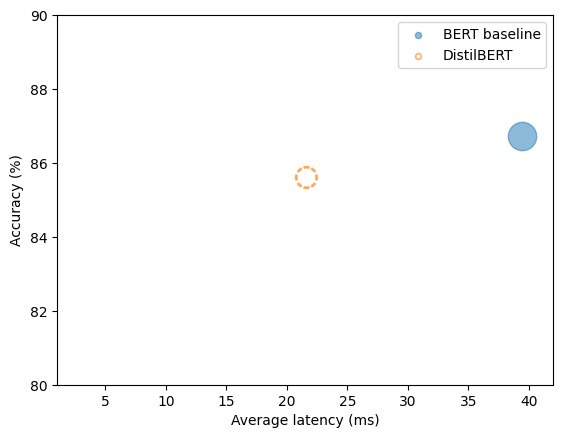

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        # 현재 최적화 방법을 점선으로 그립니다
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        alpha=0.5, s=df_opt["size_mb"], label=idx,
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        s=df_opt["size_mb"], label=idx, alpha=0.5)

    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legend_handles:
        handle.set_sizes([20])

    plt.ylim(80,90)
    # 가장 느린 모델을 사용해 x 축 범위를 정합니다
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()

plot_metrics(perf_metrics, optim_type)

### 2. 옵투나로 좋은 하이퍼파라미터 찾기

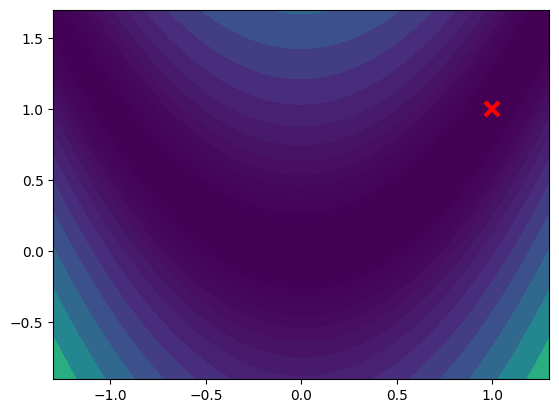

In [37]:
# 두 변수를 가진 로젠브록 함수 그래프
import matplotlib.pyplot as plt
import numpy as np

def f(x, y):
    return (1-x)**2+100*(y-x**2)**2

X, Y = np.meshgrid(np.linspace(-2, 2, 250), np.linspace(-1, 3, 250)) # meshgrid 함수를 사용하여 X와 Y 배열의 모든 조합을 생성
Z = f(X,Y) # 로젠브록 함수를 적용하여 Z 값을 계산
_, ax = plt.subplots()
ax.plot([1], [1], 'x', mew=3, markersize=10, color="red")
ax.contourf(X, Y, Z, np.logspace(-1, 3, 30), cmap='viridis', extend="both")
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-0.9, 1.7)
plt.show()

In [38]:
def objective(trial): # Optuna의 trial 객체를 인자로 받음
                      # trial 객체는 하이퍼파라미터의 제안 값을 생성하는 데 사용됨
    x = trial.suggest_float("x", -2, 2) # 하이퍼파라미터를 제안
    y = trial.suggest_float("y", -2, 2)
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2 #  로젠브록 함수의 계산 결과, 이 값이 최소화되는 x와 y의 값을 찾는 것이 최적화의 목표

In [39]:
# pip install optuna

In [40]:
import optuna

study = optuna.create_study()
study.optimize(objective, n_trials=1000)

[I 2024-03-29 21:56:01,675] A new study created in memory with name: no-name-6d083b0b-8401-4bcc-9c36-dfdd70b619ce
[I 2024-03-29 21:56:01,678] Trial 0 finished with value: 468.0337070141592 and parameters: {'x': -0.837133504458643, 'y': -1.4548017235324768}. Best is trial 0 with value: 468.0337070141592.
[I 2024-03-29 21:56:01,679] Trial 1 finished with value: 9.162646499489078 and parameters: {'x': -1.0396190534696412, 'y': 1.3044727180739142}. Best is trial 1 with value: 9.162646499489078.
[I 2024-03-29 21:56:01,680] Trial 2 finished with value: 1153.3321865078747 and parameters: {'x': -1.7827761513995326, 'y': -0.20636330247224022}. Best is trial 1 with value: 9.162646499489078.
[I 2024-03-29 21:56:01,681] Trial 3 finished with value: 220.72311451842603 and parameters: {'x': -1.3000319291779578, 'y': 0.22231952216243123}. Best is trial 1 with value: 9.162646499489078.
[I 2024-03-29 21:56:01,682] Trial 4 finished with value: 11.766914705093418 and parameters: {'x': 0.4254787645865954,

In [41]:
study.best_params

{'x': 1.0070405769282598, 'y': 1.0162912291830484}

In [42]:
# num_train_epochs, alpha, temperature의 값을 제안 (파라미터 스터디)

def hp_space(trial):
    return {"num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
        "alpha": trial.suggest_float("alpha", 0, 1),
        "temperature": trial.suggest_int("temperature", 2, 20)}

In [43]:
best_run = distilbert_trainer.hyperparameter_search(
    n_trials=20, direction="maximize", hp_space=hp_space)

[I 2024-03-29 21:56:12,779] A new study created in memory with name: no-name-c41705b0-af4d-40e9-b7b9-9a82a24f2dc8


  0%|          | 0/2862 [00:00<?, ?it/s]

{'loss': 0.3894, 'learning_rate': 1.7784765897973445e-05, 'epoch': 1.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.1960224211215973, 'eval_accuracy': 0.5916129032258064, 'eval_runtime': 5.7037, 'eval_samples_per_second': 543.507, 'eval_steps_per_second': 11.396, 'epoch': 1.0}
{'loss': 0.1632, 'learning_rate': 1.556953179594689e-05, 'epoch': 1.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.09649510681629181, 'eval_accuracy': 0.8206451612903226, 'eval_runtime': 5.6726, 'eval_samples_per_second': 546.49, 'eval_steps_per_second': 11.459, 'epoch': 2.0}
{'loss': 0.1013, 'learning_rate': 1.3354297693920338e-05, 'epoch': 2.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.06327345222234726, 'eval_accuracy': 0.8741935483870967, 'eval_runtime': 5.6632, 'eval_samples_per_second': 547.394, 'eval_steps_per_second': 11.478, 'epoch': 3.0}
{'loss': 0.0764, 'learning_rate': 1.1139063591893781e-05, 'epoch': 3.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.048404570668935776, 'eval_accuracy': 0.8948387096774194, 'eval_runtime': 5.6602, 'eval_samples_per_second': 547.687, 'eval_steps_per_second': 11.484, 'epoch': 4.0}
{'loss': 0.0631, 'learning_rate': 8.923829489867226e-06, 'epoch': 4.98}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.04065284878015518, 'eval_accuracy': 0.9038709677419355, 'eval_runtime': 5.7101, 'eval_samples_per_second': 542.899, 'eval_steps_per_second': 11.383, 'epoch': 5.0}
{'loss': 0.0555, 'learning_rate': 6.708595387840672e-06, 'epoch': 5.98}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.03551550209522247, 'eval_accuracy': 0.9109677419354839, 'eval_runtime': 5.7248, 'eval_samples_per_second': 541.505, 'eval_steps_per_second': 11.354, 'epoch': 6.0}
{'loss': 0.0505, 'learning_rate': 4.4933612858141165e-06, 'epoch': 6.98}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.03305286914110184, 'eval_accuracy': 0.9135483870967742, 'eval_runtime': 5.7002, 'eval_samples_per_second': 543.837, 'eval_steps_per_second': 11.403, 'epoch': 7.0}
{'loss': 0.0477, 'learning_rate': 2.2781271837875614e-06, 'epoch': 7.97}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.031475361436605453, 'eval_accuracy': 0.9190322580645162, 'eval_runtime': 5.6558, 'eval_samples_per_second': 548.107, 'eval_steps_per_second': 11.493, 'epoch': 8.0}
{'loss': 0.0461, 'learning_rate': 6.289308176100629e-08, 'epoch': 8.97}


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2024-03-29 22:05:42,652] Trial 0 finished with value: 0.9183870967741935 and parameters: {'num_train_epochs': 9, 'alpha': 0.6040399502524879, 'temperature': 16}. Best is trial 0 with value: 0.9183870967741935.


{'eval_loss': 0.030742721632122993, 'eval_accuracy': 0.9183870967741935, 'eval_runtime': 5.6585, 'eval_samples_per_second': 547.853, 'eval_steps_per_second': 11.487, 'epoch': 9.0}
{'train_runtime': 569.4421, 'train_samples_per_second': 241.025, 'train_steps_per_second': 5.026, 'train_loss': 0.11015269127990049, 'epoch': 9.0}


  0%|          | 0/2544 [00:00<?, ?it/s]

{'loss': 0.5006, 'learning_rate': 1.7507861635220126e-05, 'epoch': 1.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.2539463937282562, 'eval_accuracy': 0.6432258064516129, 'eval_runtime': 5.6985, 'eval_samples_per_second': 544.005, 'eval_steps_per_second': 11.407, 'epoch': 1.0}
{'loss': 0.2056, 'learning_rate': 1.5015723270440253e-05, 'epoch': 1.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.11300627887248993, 'eval_accuracy': 0.8351612903225807, 'eval_runtime': 5.6911, 'eval_samples_per_second': 544.713, 'eval_steps_per_second': 11.421, 'epoch': 2.0}
{'loss': 0.1189, 'learning_rate': 1.2523584905660378e-05, 'epoch': 2.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.06839773058891296, 'eval_accuracy': 0.8819354838709678, 'eval_runtime': 5.6638, 'eval_samples_per_second': 547.331, 'eval_steps_per_second': 11.476, 'epoch': 3.0}
{'loss': 0.086, 'learning_rate': 1.0031446540880504e-05, 'epoch': 3.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.05043986812233925, 'eval_accuracy': 0.9038709677419355, 'eval_runtime': 5.7085, 'eval_samples_per_second': 543.046, 'eval_steps_per_second': 11.386, 'epoch': 4.0}
{'loss': 0.0697, 'learning_rate': 7.539308176100629e-06, 'epoch': 4.98}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.041805073618888855, 'eval_accuracy': 0.9135483870967742, 'eval_runtime': 5.6735, 'eval_samples_per_second': 546.405, 'eval_steps_per_second': 11.457, 'epoch': 5.0}
{'loss': 0.0612, 'learning_rate': 5.047169811320756e-06, 'epoch': 5.98}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.03678557276725769, 'eval_accuracy': 0.9193548387096774, 'eval_runtime': 5.6873, 'eval_samples_per_second': 545.07, 'eval_steps_per_second': 11.429, 'epoch': 6.0}
{'loss': 0.0562, 'learning_rate': 2.555031446540881e-06, 'epoch': 6.98}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.034623291343450546, 'eval_accuracy': 0.92, 'eval_runtime': 5.738, 'eval_samples_per_second': 540.263, 'eval_steps_per_second': 11.328, 'epoch': 7.0}
{'loss': 0.0538, 'learning_rate': 6.289308176100629e-08, 'epoch': 7.97}


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2024-03-29 22:14:10,877] Trial 1 finished with value: 0.9216129032258065 and parameters: {'num_train_epochs': 8, 'alpha': 0.31787651980276166, 'temperature': 4}. Best is trial 1 with value: 0.9216129032258065.


{'eval_loss': 0.0336306132376194, 'eval_accuracy': 0.9216129032258065, 'eval_runtime': 5.661, 'eval_samples_per_second': 547.609, 'eval_steps_per_second': 11.482, 'epoch': 8.0}
{'train_runtime': 507.8932, 'train_samples_per_second': 240.208, 'train_steps_per_second': 5.009, 'train_loss': 0.14371798449904663, 'epoch': 8.0}


  0%|          | 0/3180 [00:00<?, ?it/s]

{'loss': 0.4627, 'learning_rate': 1.8006289308176103e-05, 'epoch': 1.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.23210744559764862, 'eval_accuracy': 0.6348387096774194, 'eval_runtime': 5.6752, 'eval_samples_per_second': 546.238, 'eval_steps_per_second': 11.453, 'epoch': 1.0}
{'loss': 0.1891, 'learning_rate': 1.6012578616352204e-05, 'epoch': 1.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.10542798787355423, 'eval_accuracy': 0.8364516129032258, 'eval_runtime': 5.6654, 'eval_samples_per_second': 547.176, 'eval_steps_per_second': 11.473, 'epoch': 2.0}
{'loss': 0.1106, 'learning_rate': 1.4018867924528304e-05, 'epoch': 2.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.06414199620485306, 'eval_accuracy': 0.8832258064516129, 'eval_runtime': 5.7752, 'eval_samples_per_second': 536.779, 'eval_steps_per_second': 11.255, 'epoch': 3.0}
{'loss': 0.08, 'learning_rate': 1.2025157232704403e-05, 'epoch': 3.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.04697905108332634, 'eval_accuracy': 0.9058064516129032, 'eval_runtime': 5.8182, 'eval_samples_per_second': 532.81, 'eval_steps_per_second': 11.172, 'epoch': 4.0}
{'loss': 0.0642, 'learning_rate': 1.0031446540880504e-05, 'epoch': 4.98}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.03844375163316727, 'eval_accuracy': 0.9148387096774193, 'eval_runtime': 5.827, 'eval_samples_per_second': 532.009, 'eval_steps_per_second': 11.155, 'epoch': 5.0}
{'loss': 0.0555, 'learning_rate': 8.037735849056606e-06, 'epoch': 5.98}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.033060695976018906, 'eval_accuracy': 0.9225806451612903, 'eval_runtime': 5.8413, 'eval_samples_per_second': 530.705, 'eval_steps_per_second': 11.128, 'epoch': 6.0}
{'loss': 0.0499, 'learning_rate': 6.044025157232704e-06, 'epoch': 6.98}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.030373360961675644, 'eval_accuracy': 0.9248387096774193, 'eval_runtime': 5.8434, 'eval_samples_per_second': 530.513, 'eval_steps_per_second': 11.124, 'epoch': 7.0}
{'loss': 0.0465, 'learning_rate': 4.0503144654088055e-06, 'epoch': 7.97}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.028723139315843582, 'eval_accuracy': 0.9274193548387096, 'eval_runtime': 5.8252, 'eval_samples_per_second': 532.172, 'eval_steps_per_second': 11.158, 'epoch': 8.0}
{'loss': 0.0442, 'learning_rate': 2.056603773584906e-06, 'epoch': 8.97}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.02741728536784649, 'eval_accuracy': 0.9290322580645162, 'eval_runtime': 5.8211, 'eval_samples_per_second': 532.549, 'eval_steps_per_second': 11.166, 'epoch': 9.0}
{'loss': 0.043, 'learning_rate': 6.289308176100629e-08, 'epoch': 9.97}


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2024-03-29 22:24:53,834] Trial 2 finished with value: 0.9290322580645162 and parameters: {'num_train_epochs': 10, 'alpha': 0.8044624881996022, 'temperature': 5}. Best is trial 2 with value: 0.9290322580645162.


{'eval_loss': 0.026990484446287155, 'eval_accuracy': 0.9290322580645162, 'eval_runtime': 5.8287, 'eval_samples_per_second': 531.855, 'eval_steps_per_second': 11.152, 'epoch': 10.0}
{'train_runtime': 642.6044, 'train_samples_per_second': 237.316, 'train_steps_per_second': 4.949, 'train_loss': 0.11432733334272913, 'epoch': 10.0}


  0%|          | 0/2226 [00:00<?, ?it/s]

{'loss': 0.4206, 'learning_rate': 1.7151841868823e-05, 'epoch': 1.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.21466155350208282, 'eval_accuracy': 0.6048387096774194, 'eval_runtime': 5.8199, 'eval_samples_per_second': 532.659, 'eval_steps_per_second': 11.169, 'epoch': 1.0}
{'loss': 0.1785, 'learning_rate': 1.4303683737646003e-05, 'epoch': 1.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.10510226339101791, 'eval_accuracy': 0.8193548387096774, 'eval_runtime': 5.8246, 'eval_samples_per_second': 532.228, 'eval_steps_per_second': 11.16, 'epoch': 2.0}
{'loss': 0.111, 'learning_rate': 1.1455525606469004e-05, 'epoch': 2.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.06921280920505524, 'eval_accuracy': 0.8719354838709678, 'eval_runtime': 5.8294, 'eval_samples_per_second': 531.791, 'eval_steps_per_second': 11.15, 'epoch': 3.0}
{'loss': 0.0845, 'learning_rate': 8.607367475292004e-06, 'epoch': 3.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.05373425409197807, 'eval_accuracy': 0.8929032258064517, 'eval_runtime': 5.8244, 'eval_samples_per_second': 532.248, 'eval_steps_per_second': 11.16, 'epoch': 4.0}
{'loss': 0.0709, 'learning_rate': 5.759209344115006e-06, 'epoch': 4.98}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.04598509892821312, 'eval_accuracy': 0.8990322580645161, 'eval_runtime': 5.8225, 'eval_samples_per_second': 532.416, 'eval_steps_per_second': 11.164, 'epoch': 5.0}
{'loss': 0.064, 'learning_rate': 2.911051212938006e-06, 'epoch': 5.98}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.04171634837985039, 'eval_accuracy': 0.9045161290322581, 'eval_runtime': 5.835, 'eval_samples_per_second': 531.275, 'eval_steps_per_second': 11.14, 'epoch': 6.0}
{'loss': 0.0604, 'learning_rate': 6.289308176100629e-08, 'epoch': 6.98}


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2024-03-29 22:32:21,812] Trial 3 finished with value: 0.9058064516129032 and parameters: {'num_train_epochs': 7, 'alpha': 0.9563685137531179, 'temperature': 8}. Best is trial 2 with value: 0.9290322580645162.


{'eval_loss': 0.04051298648118973, 'eval_accuracy': 0.9058064516129032, 'eval_runtime': 5.871, 'eval_samples_per_second': 528.018, 'eval_steps_per_second': 11.071, 'epoch': 7.0}
{'train_runtime': 447.606, 'train_samples_per_second': 238.491, 'train_steps_per_second': 4.973, 'train_loss': 0.14116031065355628, 'epoch': 7.0}


  0%|          | 0/2544 [00:00<?, ?it/s]

{'loss': 0.3861, 'learning_rate': 1.7507861635220126e-05, 'epoch': 1.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.19525150954723358, 'eval_accuracy': 0.5867741935483871, 'eval_runtime': 5.8217, 'eval_samples_per_second': 532.491, 'eval_steps_per_second': 11.165, 'epoch': 1.0}
{'loss': 0.1631, 'learning_rate': 1.5015723270440253e-05, 'epoch': 1.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.09718254208564758, 'eval_accuracy': 0.8170967741935484, 'eval_runtime': 5.8241, 'eval_samples_per_second': 532.272, 'eval_steps_per_second': 11.161, 'epoch': 2.0}
{'loss': 0.1023, 'learning_rate': 1.2523584905660378e-05, 'epoch': 2.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.06467867642641068, 'eval_accuracy': 0.8712903225806452, 'eval_runtime': 5.82, 'eval_samples_per_second': 532.643, 'eval_steps_per_second': 11.168, 'epoch': 3.0}
{'loss': 0.078, 'learning_rate': 1.0031446540880504e-05, 'epoch': 3.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.050168342888355255, 'eval_accuracy': 0.8916129032258064, 'eval_runtime': 5.8257, 'eval_samples_per_second': 532.128, 'eval_steps_per_second': 11.158, 'epoch': 4.0}
{'loss': 0.0651, 'learning_rate': 7.539308176100629e-06, 'epoch': 4.98}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.04264938831329346, 'eval_accuracy': 0.9016129032258065, 'eval_runtime': 5.8306, 'eval_samples_per_second': 531.678, 'eval_steps_per_second': 11.148, 'epoch': 5.0}
{'loss': 0.058, 'learning_rate': 5.047169811320756e-06, 'epoch': 5.98}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.03787907585501671, 'eval_accuracy': 0.9074193548387097, 'eval_runtime': 5.8362, 'eval_samples_per_second': 531.165, 'eval_steps_per_second': 11.137, 'epoch': 6.0}
{'loss': 0.0536, 'learning_rate': 2.555031446540881e-06, 'epoch': 6.98}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.03581305593252182, 'eval_accuracy': 0.9087096774193548, 'eval_runtime': 5.5667, 'eval_samples_per_second': 556.882, 'eval_steps_per_second': 11.677, 'epoch': 7.0}
{'loss': 0.0514, 'learning_rate': 6.289308176100629e-08, 'epoch': 7.97}


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2024-03-29 22:40:51,397] Trial 4 finished with value: 0.9116129032258065 and parameters: {'num_train_epochs': 8, 'alpha': 0.5816997702743193, 'temperature': 19}. Best is trial 2 with value: 0.9290322580645162.


{'eval_loss': 0.03481480851769447, 'eval_accuracy': 0.9116129032258065, 'eval_runtime': 5.5629, 'eval_samples_per_second': 557.267, 'eval_steps_per_second': 11.685, 'epoch': 8.0}
{'train_runtime': 509.2201, 'train_samples_per_second': 239.582, 'train_steps_per_second': 4.996, 'train_loss': 0.11949729077143115, 'epoch': 8.0}


  0%|          | 0/1908 [00:00<?, ?it/s]

{'loss': 0.5814, 'learning_rate': 1.6677148846960168e-05, 'epoch': 1.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.3010924160480499, 'eval_accuracy': 0.6529032258064517, 'eval_runtime': 5.5564, 'eval_samples_per_second': 557.911, 'eval_steps_per_second': 11.698, 'epoch': 1.0}
{'loss': 0.2417, 'learning_rate': 1.3354297693920338e-05, 'epoch': 1.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.13035038113594055, 'eval_accuracy': 0.8283870967741935, 'eval_runtime': 5.5531, 'eval_samples_per_second': 558.25, 'eval_steps_per_second': 11.705, 'epoch': 2.0}
{'loss': 0.1369, 'learning_rate': 1.0031446540880504e-05, 'epoch': 2.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.07831805944442749, 'eval_accuracy': 0.8809677419354839, 'eval_runtime': 5.5659, 'eval_samples_per_second': 556.961, 'eval_steps_per_second': 11.678, 'epoch': 3.0}
{'loss': 0.0995, 'learning_rate': 6.708595387840672e-06, 'epoch': 3.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.0591108538210392, 'eval_accuracy': 0.8977419354838709, 'eval_runtime': 5.5547, 'eval_samples_per_second': 558.088, 'eval_steps_per_second': 11.702, 'epoch': 4.0}
{'loss': 0.0828, 'learning_rate': 3.385744234800839e-06, 'epoch': 4.98}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.050941672176122665, 'eval_accuracy': 0.9083870967741936, 'eval_runtime': 5.5529, 'eval_samples_per_second': 558.27, 'eval_steps_per_second': 11.706, 'epoch': 5.0}
{'loss': 0.076, 'learning_rate': 6.289308176100629e-08, 'epoch': 5.98}


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2024-03-29 22:47:03,820] Trial 5 pruned. 


{'eval_loss': 0.04845298081636429, 'eval_accuracy': 0.9087096774193548, 'eval_runtime': 5.5584, 'eval_samples_per_second': 557.717, 'eval_steps_per_second': 11.694, 'epoch': 6.0}


  0%|          | 0/2862 [00:00<?, ?it/s]

{'loss': 0.388, 'learning_rate': 1.7784765897973445e-05, 'epoch': 1.0}


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2024-03-29 22:48:05,991] Trial 6 pruned. 


{'eval_loss': 0.19516536593437195, 'eval_accuracy': 0.5925806451612903, 'eval_runtime': 5.5521, 'eval_samples_per_second': 558.344, 'eval_steps_per_second': 11.707, 'epoch': 1.0}


  0%|          | 0/2862 [00:00<?, ?it/s]

{'loss': 0.3935, 'learning_rate': 1.7784765897973445e-05, 'epoch': 1.0}


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2024-03-29 22:49:08,163] Trial 7 pruned. 


{'eval_loss': 0.19817382097244263, 'eval_accuracy': 0.5961290322580645, 'eval_runtime': 5.5511, 'eval_samples_per_second': 558.445, 'eval_steps_per_second': 11.709, 'epoch': 1.0}


  0%|          | 0/2226 [00:00<?, ?it/s]

{'loss': 0.8105, 'learning_rate': 1.7151841868823e-05, 'epoch': 1.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.4190521836280823, 'eval_accuracy': 0.6838709677419355, 'eval_runtime': 5.5594, 'eval_samples_per_second': 557.617, 'eval_steps_per_second': 11.692, 'epoch': 1.0}
{'loss': 0.3187, 'learning_rate': 1.4303683737646003e-05, 'epoch': 1.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.15057165920734406, 'eval_accuracy': 0.8335483870967741, 'eval_runtime': 5.5544, 'eval_samples_per_second': 558.118, 'eval_steps_per_second': 11.702, 'epoch': 2.0}
{'loss': 0.1527, 'learning_rate': 1.1455525606469004e-05, 'epoch': 2.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.07822834700345993, 'eval_accuracy': 0.8890322580645161, 'eval_runtime': 5.5585, 'eval_samples_per_second': 557.703, 'eval_steps_per_second': 11.694, 'epoch': 3.0}
{'loss': 0.1002, 'learning_rate': 8.607367475292004e-06, 'epoch': 3.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.05623452365398407, 'eval_accuracy': 0.9141935483870968, 'eval_runtime': 5.5519, 'eval_samples_per_second': 558.369, 'eval_steps_per_second': 11.708, 'epoch': 4.0}
{'loss': 0.0793, 'learning_rate': 5.759209344115006e-06, 'epoch': 4.98}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.04756658151745796, 'eval_accuracy': 0.9212903225806451, 'eval_runtime': 5.5574, 'eval_samples_per_second': 557.819, 'eval_steps_per_second': 11.696, 'epoch': 5.0}
{'loss': 0.0701, 'learning_rate': 2.911051212938006e-06, 'epoch': 5.98}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.04337819665670395, 'eval_accuracy': 0.9251612903225807, 'eval_runtime': 5.5531, 'eval_samples_per_second': 558.251, 'eval_steps_per_second': 11.705, 'epoch': 6.0}
{'loss': 0.0656, 'learning_rate': 6.289308176100629e-08, 'epoch': 6.98}


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2024-03-29 22:56:22,688] Trial 8 finished with value: 0.9258064516129032 and parameters: {'num_train_epochs': 7, 'alpha': 0.895271894018041, 'temperature': 2}. Best is trial 2 with value: 0.9290322580645162.


{'eval_loss': 0.04211694002151489, 'eval_accuracy': 0.9258064516129032, 'eval_runtime': 5.5519, 'eval_samples_per_second': 558.363, 'eval_steps_per_second': 11.708, 'epoch': 7.0}
{'train_runtime': 434.1761, 'train_samples_per_second': 245.868, 'train_steps_per_second': 5.127, 'train_loss': 0.22765167365444747, 'epoch': 7.0}


  0%|          | 0/2544 [00:00<?, ?it/s]

{'loss': 0.3992, 'learning_rate': 1.7507861635220126e-05, 'epoch': 1.0}


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2024-03-29 22:57:24,848] Trial 9 pruned. 


{'eval_loss': 0.20197610557079315, 'eval_accuracy': 0.5958064516129032, 'eval_runtime': 5.5582, 'eval_samples_per_second': 557.73, 'eval_steps_per_second': 11.694, 'epoch': 1.0}


  0%|          | 0/3180 [00:00<?, ?it/s]

{'loss': 0.4181, 'learning_rate': 1.8006289308176103e-05, 'epoch': 1.0}


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2024-03-29 22:58:26,996] Trial 10 pruned. 


{'eval_loss': 0.20976325869560242, 'eval_accuracy': 0.6112903225806452, 'eval_runtime': 5.5525, 'eval_samples_per_second': 558.307, 'eval_steps_per_second': 11.706, 'epoch': 1.0}


  0%|          | 0/1590 [00:00<?, ?it/s]

{'loss': 0.8163, 'learning_rate': 1.6012578616352204e-05, 'epoch': 1.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.4339969754219055, 'eval_accuracy': 0.6735483870967742, 'eval_runtime': 5.5523, 'eval_samples_per_second': 558.331, 'eval_steps_per_second': 11.707, 'epoch': 1.0}
{'loss': 0.3391, 'learning_rate': 1.2025157232704403e-05, 'epoch': 1.99}


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2024-03-29 23:00:31,085] Trial 11 pruned. 


{'eval_loss': 0.17117609083652496, 'eval_accuracy': 0.8225806451612904, 'eval_runtime': 5.61, 'eval_samples_per_second': 552.584, 'eval_steps_per_second': 11.586, 'epoch': 2.0}


  0%|          | 0/1908 [00:00<?, ?it/s]

{'loss': 0.4448, 'learning_rate': 1.6677148846960168e-05, 'epoch': 1.0}


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2024-03-29 23:01:36,671] Trial 12 pruned. 


{'eval_loss': 0.22916248440742493, 'eval_accuracy': 0.6074193548387097, 'eval_runtime': 5.8014, 'eval_samples_per_second': 534.354, 'eval_steps_per_second': 11.204, 'epoch': 1.0}


  0%|          | 0/3180 [00:00<?, ?it/s]

{'loss': 0.4276, 'learning_rate': 1.8006289308176103e-05, 'epoch': 1.0}


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2024-03-29 23:02:45,714] Trial 13 pruned. 


{'eval_loss': 0.21468111872673035, 'eval_accuracy': 0.6138709677419355, 'eval_runtime': 6.8523, 'eval_samples_per_second': 452.404, 'eval_steps_per_second': 9.486, 'epoch': 1.0}


  0%|          | 0/2226 [00:00<?, ?it/s]

{'loss': 0.4649, 'learning_rate': 1.7151841868823e-05, 'epoch': 1.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.23730216920375824, 'eval_accuracy': 0.6270967741935484, 'eval_runtime': 5.9916, 'eval_samples_per_second': 517.389, 'eval_steps_per_second': 10.848, 'epoch': 1.0}
{'loss': 0.1952, 'learning_rate': 1.4303683737646003e-05, 'epoch': 1.99}


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2024-03-29 23:05:01,841] Trial 14 pruned. 


{'eval_loss': 0.11144395172595978, 'eval_accuracy': 0.8261290322580646, 'eval_runtime': 5.8156, 'eval_samples_per_second': 533.053, 'eval_steps_per_second': 11.177, 'epoch': 2.0}


  0%|          | 0/1908 [00:00<?, ?it/s]

{'loss': 0.4092, 'learning_rate': 1.6677148846960168e-05, 'epoch': 1.0}


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2024-03-29 23:06:07,273] Trial 15 pruned. 


{'eval_loss': 0.2106281965970993, 'eval_accuracy': 0.594516129032258, 'eval_runtime': 5.8279, 'eval_samples_per_second': 531.928, 'eval_steps_per_second': 11.153, 'epoch': 1.0}


  0%|          | 0/2226 [00:00<?, ?it/s]

{'loss': 0.8105, 'learning_rate': 1.7151841868823e-05, 'epoch': 1.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.4190521836280823, 'eval_accuracy': 0.6838709677419355, 'eval_runtime': 5.809, 'eval_samples_per_second': 533.653, 'eval_steps_per_second': 11.19, 'epoch': 1.0}
{'loss': 0.3187, 'learning_rate': 1.4303683737646003e-05, 'epoch': 1.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.15057165920734406, 'eval_accuracy': 0.8335483870967741, 'eval_runtime': 5.8068, 'eval_samples_per_second': 533.855, 'eval_steps_per_second': 11.194, 'epoch': 2.0}
{'loss': 0.1527, 'learning_rate': 1.1455525606469004e-05, 'epoch': 2.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.07822834700345993, 'eval_accuracy': 0.8890322580645161, 'eval_runtime': 6.0832, 'eval_samples_per_second': 509.603, 'eval_steps_per_second': 10.685, 'epoch': 3.0}
{'loss': 0.1002, 'learning_rate': 8.607367475292004e-06, 'epoch': 3.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.05623452365398407, 'eval_accuracy': 0.9141935483870968, 'eval_runtime': 5.7878, 'eval_samples_per_second': 535.605, 'eval_steps_per_second': 11.23, 'epoch': 4.0}
{'loss': 0.0793, 'learning_rate': 5.759209344115006e-06, 'epoch': 4.98}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.04756658151745796, 'eval_accuracy': 0.9212903225806451, 'eval_runtime': 5.8059, 'eval_samples_per_second': 533.936, 'eval_steps_per_second': 11.195, 'epoch': 5.0}
{'loss': 0.0701, 'learning_rate': 2.911051212938006e-06, 'epoch': 5.98}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.04337819665670395, 'eval_accuracy': 0.9251612903225807, 'eval_runtime': 5.788, 'eval_samples_per_second': 535.593, 'eval_steps_per_second': 11.23, 'epoch': 6.0}
{'loss': 0.0656, 'learning_rate': 6.289308176100629e-08, 'epoch': 6.98}


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2024-03-29 23:13:46,938] Trial 16 finished with value: 0.9258064516129032 and parameters: {'num_train_epochs': 7, 'alpha': 0.7085068174465694, 'temperature': 2}. Best is trial 2 with value: 0.9290322580645162.


{'eval_loss': 0.04211694002151489, 'eval_accuracy': 0.9258064516129032, 'eval_runtime': 5.8183, 'eval_samples_per_second': 532.802, 'eval_steps_per_second': 11.172, 'epoch': 7.0}
{'train_runtime': 459.3079, 'train_samples_per_second': 232.415, 'train_steps_per_second': 4.846, 'train_loss': 0.22765167365444747, 'epoch': 7.0}


  0%|          | 0/1590 [00:00<?, ?it/s]

{'loss': 0.4108, 'learning_rate': 1.6012578616352204e-05, 'epoch': 1.0}


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2024-03-29 23:14:52,025] Trial 17 pruned. 


{'eval_loss': 0.21416842937469482, 'eval_accuracy': 0.5812903225806452, 'eval_runtime': 5.7811, 'eval_samples_per_second': 536.232, 'eval_steps_per_second': 11.244, 'epoch': 1.0}


  0%|          | 0/3180 [00:00<?, ?it/s]

{'loss': 0.4627, 'learning_rate': 1.8006289308176103e-05, 'epoch': 1.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.23210744559764862, 'eval_accuracy': 0.6348387096774194, 'eval_runtime': 5.7809, 'eval_samples_per_second': 536.251, 'eval_steps_per_second': 11.244, 'epoch': 1.0}
{'loss': 0.1891, 'learning_rate': 1.6012578616352204e-05, 'epoch': 1.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.10542798787355423, 'eval_accuracy': 0.8364516129032258, 'eval_runtime': 5.7696, 'eval_samples_per_second': 537.301, 'eval_steps_per_second': 11.266, 'epoch': 2.0}
{'loss': 0.1106, 'learning_rate': 1.4018867924528304e-05, 'epoch': 2.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.06414199620485306, 'eval_accuracy': 0.8832258064516129, 'eval_runtime': 5.8188, 'eval_samples_per_second': 532.755, 'eval_steps_per_second': 11.171, 'epoch': 3.0}
{'loss': 0.08, 'learning_rate': 1.2025157232704403e-05, 'epoch': 3.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.04697905108332634, 'eval_accuracy': 0.9058064516129032, 'eval_runtime': 6.1903, 'eval_samples_per_second': 500.782, 'eval_steps_per_second': 10.5, 'epoch': 4.0}
{'loss': 0.0642, 'learning_rate': 1.0031446540880504e-05, 'epoch': 4.98}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.03844375163316727, 'eval_accuracy': 0.9148387096774193, 'eval_runtime': 5.8127, 'eval_samples_per_second': 533.311, 'eval_steps_per_second': 11.182, 'epoch': 5.0}
{'loss': 0.0555, 'learning_rate': 8.037735849056606e-06, 'epoch': 5.98}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.033060695976018906, 'eval_accuracy': 0.9225806451612903, 'eval_runtime': 5.923, 'eval_samples_per_second': 523.386, 'eval_steps_per_second': 10.974, 'epoch': 6.0}
{'loss': 0.0499, 'learning_rate': 6.044025157232704e-06, 'epoch': 6.98}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.030373360961675644, 'eval_accuracy': 0.9248387096774193, 'eval_runtime': 6.0924, 'eval_samples_per_second': 508.833, 'eval_steps_per_second': 10.669, 'epoch': 7.0}
{'loss': 0.0465, 'learning_rate': 4.0503144654088055e-06, 'epoch': 7.97}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.028723139315843582, 'eval_accuracy': 0.9274193548387096, 'eval_runtime': 6.2903, 'eval_samples_per_second': 492.824, 'eval_steps_per_second': 10.333, 'epoch': 8.0}
{'loss': 0.0442, 'learning_rate': 2.056603773584906e-06, 'epoch': 8.97}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.02741728536784649, 'eval_accuracy': 0.9290322580645162, 'eval_runtime': 5.9242, 'eval_samples_per_second': 523.28, 'eval_steps_per_second': 10.972, 'epoch': 9.0}
{'loss': 0.043, 'learning_rate': 6.289308176100629e-08, 'epoch': 9.97}


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2024-03-29 23:26:04,938] Trial 18 finished with value: 0.9290322580645162 and parameters: {'num_train_epochs': 10, 'alpha': 0.45043987994338197, 'temperature': 5}. Best is trial 2 with value: 0.9290322580645162.


{'eval_loss': 0.026990484446287155, 'eval_accuracy': 0.9290322580645162, 'eval_runtime': 5.9776, 'eval_samples_per_second': 518.601, 'eval_steps_per_second': 10.874, 'epoch': 10.0}
{'train_runtime': 672.5536, 'train_samples_per_second': 226.748, 'train_steps_per_second': 4.728, 'train_loss': 0.11432733334272913, 'epoch': 10.0}


  0%|          | 0/3180 [00:00<?, ?it/s]

{'loss': 0.4627, 'learning_rate': 1.8006289308176103e-05, 'epoch': 1.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.23210744559764862, 'eval_accuracy': 0.6348387096774194, 'eval_runtime': 5.7499, 'eval_samples_per_second': 539.139, 'eval_steps_per_second': 11.305, 'epoch': 1.0}
{'loss': 0.1891, 'learning_rate': 1.6012578616352204e-05, 'epoch': 1.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.10542798787355423, 'eval_accuracy': 0.8364516129032258, 'eval_runtime': 5.7211, 'eval_samples_per_second': 541.851, 'eval_steps_per_second': 11.361, 'epoch': 2.0}
{'loss': 0.1106, 'learning_rate': 1.4018867924528304e-05, 'epoch': 2.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.06414199620485306, 'eval_accuracy': 0.8832258064516129, 'eval_runtime': 5.9249, 'eval_samples_per_second': 523.217, 'eval_steps_per_second': 10.971, 'epoch': 3.0}
{'loss': 0.08, 'learning_rate': 1.2025157232704403e-05, 'epoch': 3.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.04697905108332634, 'eval_accuracy': 0.9058064516129032, 'eval_runtime': 6.0632, 'eval_samples_per_second': 511.284, 'eval_steps_per_second': 10.72, 'epoch': 4.0}
{'loss': 0.0642, 'learning_rate': 1.0031446540880504e-05, 'epoch': 4.98}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.03844375163316727, 'eval_accuracy': 0.9148387096774193, 'eval_runtime': 5.7531, 'eval_samples_per_second': 538.84, 'eval_steps_per_second': 11.298, 'epoch': 5.0}
{'loss': 0.0555, 'learning_rate': 8.037735849056606e-06, 'epoch': 5.98}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.033060695976018906, 'eval_accuracy': 0.9225806451612903, 'eval_runtime': 5.7626, 'eval_samples_per_second': 537.948, 'eval_steps_per_second': 11.28, 'epoch': 6.0}
{'loss': 0.0499, 'learning_rate': 6.044025157232704e-06, 'epoch': 6.98}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.030373360961675644, 'eval_accuracy': 0.9248387096774193, 'eval_runtime': 5.7458, 'eval_samples_per_second': 539.527, 'eval_steps_per_second': 11.313, 'epoch': 7.0}
{'loss': 0.0465, 'learning_rate': 4.0503144654088055e-06, 'epoch': 7.97}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.028723139315843582, 'eval_accuracy': 0.9274193548387096, 'eval_runtime': 5.957, 'eval_samples_per_second': 520.4, 'eval_steps_per_second': 10.912, 'epoch': 8.0}
{'loss': 0.0442, 'learning_rate': 2.056603773584906e-06, 'epoch': 8.97}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.02741728536784649, 'eval_accuracy': 0.9290322580645162, 'eval_runtime': 6.0304, 'eval_samples_per_second': 514.059, 'eval_steps_per_second': 10.779, 'epoch': 9.0}
{'loss': 0.043, 'learning_rate': 6.289308176100629e-08, 'epoch': 9.97}


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2024-03-29 23:36:59,597] Trial 19 finished with value: 0.9290322580645162 and parameters: {'num_train_epochs': 10, 'alpha': 0.43878833353749486, 'temperature': 5}. Best is trial 2 with value: 0.9290322580645162.


{'eval_loss': 0.026990484446287155, 'eval_accuracy': 0.9290322580645162, 'eval_runtime': 5.8034, 'eval_samples_per_second': 534.168, 'eval_steps_per_second': 11.2, 'epoch': 10.0}
{'train_runtime': 654.2343, 'train_samples_per_second': 233.097, 'train_steps_per_second': 4.861, 'train_loss': 0.11432733334272913, 'epoch': 10.0}


In [44]:
print(best_run)

BestRun(run_id='2', objective=0.9290322580645162, hyperparameters={'num_train_epochs': 10, 'alpha': 0.8044624881996022, 'temperature': 5}, run_summary=None)


In [45]:
''' student_training_args의 속성을 최적의 하이퍼파라미터 값으로 변경 '''
for k,v in best_run.hyperparameters.items(): 
    setattr(student_training_args, k, v) 


''' 훈련 모델 저장 '''
distilled_ckpt = "distilbert-base-uncased-distilled-clinc" 
student_training_args.output_dir = distilled_ckpt


''' 최적의 매개변수로 새로운 Trainer 객체 생성 '''
distil_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distil_trainer.train(); # 모델 훈련

  0%|          | 0/3180 [00:00<?, ?it/s]

{'loss': 3.5585, 'learning_rate': 1.8006289308176103e-05, 'epoch': 1.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 2.6636199951171875, 'eval_accuracy': 0.7480645161290322, 'eval_runtime': 7.1728, 'eval_samples_per_second': 432.185, 'eval_steps_per_second': 9.062, 'epoch': 1.0}
{'loss': 2.0635, 'learning_rate': 1.6012578616352204e-05, 'epoch': 1.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 1.3680261373519897, 'eval_accuracy': 0.8703225806451613, 'eval_runtime': 6.8595, 'eval_samples_per_second': 451.927, 'eval_steps_per_second': 9.476, 'epoch': 2.0}
{'loss': 1.0524, 'learning_rate': 1.4018867924528304e-05, 'epoch': 2.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.7254437804222107, 'eval_accuracy': 0.9145161290322581, 'eval_runtime': 6.7855, 'eval_samples_per_second': 456.854, 'eval_steps_per_second': 9.579, 'epoch': 3.0}
{'loss': 0.5645, 'learning_rate': 1.2025157232704403e-05, 'epoch': 3.99}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.4720883369445801, 'eval_accuracy': 0.9332258064516129, 'eval_runtime': 6.214, 'eval_samples_per_second': 498.871, 'eval_steps_per_second': 10.46, 'epoch': 4.0}
{'loss': 0.348, 'learning_rate': 1.0031446540880504e-05, 'epoch': 4.98}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.3693273663520813, 'eval_accuracy': 0.942258064516129, 'eval_runtime': 6.2363, 'eval_samples_per_second': 497.089, 'eval_steps_per_second': 10.423, 'epoch': 5.0}
{'loss': 0.2487, 'learning_rate': 8.037735849056606e-06, 'epoch': 5.98}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.3293360471725464, 'eval_accuracy': 0.9435483870967742, 'eval_runtime': 6.1881, 'eval_samples_per_second': 500.965, 'eval_steps_per_second': 10.504, 'epoch': 6.0}
{'loss': 0.1972, 'learning_rate': 6.044025157232704e-06, 'epoch': 6.98}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.30361199378967285, 'eval_accuracy': 0.944516129032258, 'eval_runtime': 6.2274, 'eval_samples_per_second': 497.804, 'eval_steps_per_second': 10.438, 'epoch': 7.0}
{'loss': 0.1705, 'learning_rate': 4.0503144654088055e-06, 'epoch': 7.97}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.29590514302253723, 'eval_accuracy': 0.9458064516129032, 'eval_runtime': 6.1928, 'eval_samples_per_second': 500.583, 'eval_steps_per_second': 10.496, 'epoch': 8.0}
{'loss': 0.1551, 'learning_rate': 2.056603773584906e-06, 'epoch': 8.97}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.28836512565612793, 'eval_accuracy': 0.9454838709677419, 'eval_runtime': 6.5374, 'eval_samples_per_second': 474.196, 'eval_steps_per_second': 9.943, 'epoch': 9.0}
{'loss': 0.1474, 'learning_rate': 6.289308176100629e-08, 'epoch': 9.97}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.2874309718608856, 'eval_accuracy': 0.9464516129032258, 'eval_runtime': 6.0428, 'eval_samples_per_second': 513.008, 'eval_steps_per_second': 10.757, 'epoch': 10.0}
{'train_runtime': 768.9828, 'train_samples_per_second': 198.314, 'train_steps_per_second': 4.135, 'train_loss': 0.8483815058222357, 'epoch': 10.0}


In [46]:
distil_trainer.push_to_hub("Training complete")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.86k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/thebluedays/distilbert-base-uncased-distilled-clinc/commit/3bedd4cfb4695d5080144a65ba09fe26255ccf1a', commit_message='Training complete', commit_description='', oid='3bedd4cfb4695d5080144a65ba09fe26255ccf1a', pr_url=None, pr_revision=None, pr_num=None)

### 정제 모델 벤치마크 수행하기

In [47]:
# `haesun`를 자신의 허브 사용자 이름으로 바꾸세요.
distilled_ckpt = "haesun/distilbert-base-uncased-distilled-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt)
optim_type = "Distillation"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 255.88
평균 레이턴시 (ms) - 20.47 +\- 0.88
테스트 세트 정확도 - 0.857


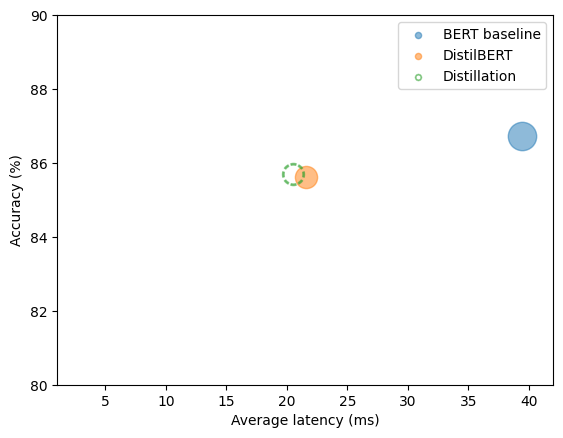

In [48]:
plot_metrics(perf_metrics, optim_type)

## 3. 양자화로 모델 속도 높이기

### 사이드바: 부동 소수점 숫자 vs 고정 소수점 숫자

### End sidebar

<img alt="Mapping floating-point numbers to 8-bit integers" width="800" caption="Quantizing floating-point numbers as unsigned 8-bit integers (courtesy of Manas Sahni)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_fp32-to-int8.png?raw=1" id="fp32toint8"/>

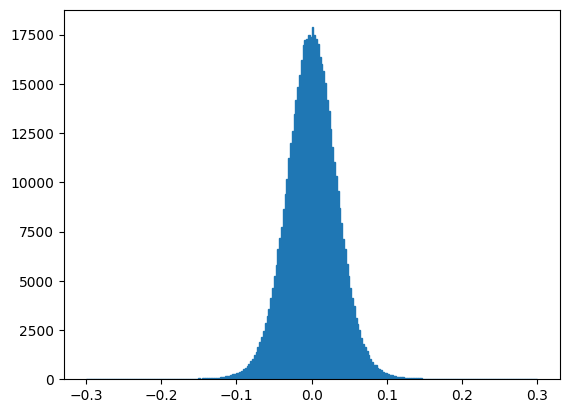

In [49]:
import matplotlib.pyplot as plt

state_dict = pipe.model.state_dict()                                              # 모델의 파라미터를 호출
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]   # 특정 가중치를 선택
                                                                                  # DistilBERT 모델의 첫 번째 레이어에 있는 attention mechanism의 가중치를 선택
plt.hist(weights.flatten().numpy(), bins=250, range=(-0.3,0.3), edgecolor="C0")
plt.show()

In [50]:
zero_point = 0 # 양자화 과정에서 사용되는 zero point를 0으로 설정
               # Zero point는 양자화된 값이 원래의 실수 값에 가깝게 유지되도록 하는 역할
scale = (weights.max() - weights.min()) / (127 - (-128)) # 가중치의 최대값과 최소값의 차이를 계산
                                                         # 이를 8비트 정수의 범위인 -128부터 127까지의 차이로 나누어 scale 값을 계산

In [51]:
(weights / scale + zero_point).clamp(-128, 127).round().char()
# 가중치를 scale 값으로 나누고 zero point를 더함 (가중치 : -128 ~ 127)
# clamp : 범위를 초과하는 값을 잘라냄
# round : 반올림하고
# char : 8비트 정수로 변환

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  9,   3,   2,  ...,  -4,   7,   1],
        [ -9,  -6,   5,  ...,   0,   5,  -3],
        ...,
        [  6,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  11,  -8, -13],
        [-13,  -1, -10,  ...,   8,   2,  -1]], dtype=torch.int8)

In [52]:
from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  9,   3,   2,  ...,  -4,   7,   1],
        [ -9,  -6,   5,  ...,   0,   5,  -3],
        ...,
        [  6,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  11,  -8, -13],
        [-13,  -1, -10,  ...,   8,   2,  -1]], dtype=torch.int8)

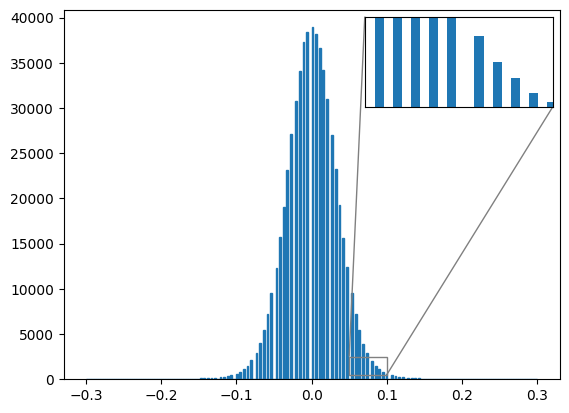

In [53]:
''' 트랜스포머 가중치에서 양자화 효과 '''
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset

''' 히스토그램 그리기 '''
fig, ax = plt.subplots()
ax.hist(quantized_weights.dequantize().flatten().numpy(),
         bins=250, range=(-0.3,0.3), edgecolor="C0");

''' 확대 그림 만들기 '''
axins = zoomed_inset_axes(ax, 5, loc='upper right')
axins.hist(quantized_weights.dequantize().flatten().numpy(),
         bins=250, range=(-0.3,0.3));
x1, x2, y1, y2 = 0.05, 0.1, 500, 2500
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.axes.xaxis.set_visible(False)
axins.axes.yaxis.set_visible(False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.show()

In [58]:
%%timeit # 가중치 행렬의 내적 연산을 수행하는 데 걸리는 시간을 측정
         # 매직 커맨드, 그 아래에 있는 코드 블록의 실행 시간 측정
weights @ weights

6.91 ms ± 257 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [59]:
from torch.nn.quantized import QFunctional # 양자화 연산을 수행하는 기능

q_fn = QFunctional()

In [60]:
%%timeit
q_fn.mul(quantized_weights, quantized_weights) # quantized_weights 텐서 자신과의 곱셈을 수행

131 µs ± 2.9 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [61]:
''' 원래의 가중치 행렬(weights)과 양자화된 가중치 행렬(quantized_weights)의 메모리 크기 비율을 계산 '''

import sys

sys.getsizeof(weights.untyped_storage()) / sys.getsizeof(quantized_weights.untyped_storage())
# weights.untyped_storage() : weights 텐서의 저장소를 반환
# sys.getsizeof() : 저장소의 메모리 크기를 바이트 단위로 반환

3.9995931541403347

In [62]:
from torch.quantization import quantize_dynamic

model_ckpt = "thebluedays/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt).to("cpu"))

model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

### 양자화된 모델의 벤치마크 수행하기

In [63]:
pipe = pipeline("text-classification", model=model_quantized,
                tokenizer=tokenizer)
optim_type = "Distillation + quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 132.39
평균 레이턴시 (ms) - 17.62 +\- 3.59
테스트 세트 정확도 - 0.862


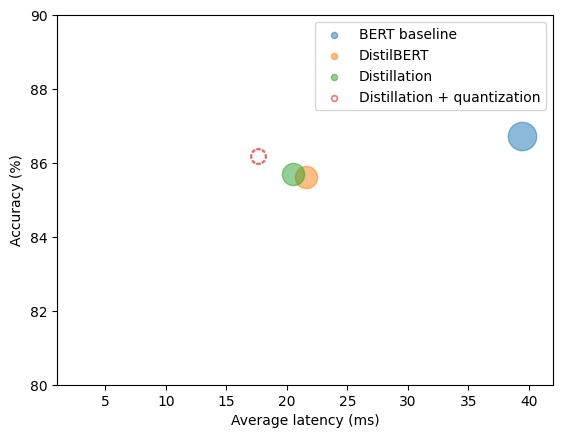

In [64]:
plot_metrics(perf_metrics, optim_type)

## 4. ONNX와 ONNX 런타임으로 추론 최적화하기

https://velog.io/@hsp/model-inference-with-ONNX

<img alt="Example ONNX graph" width="500" caption="A section of the ONNX graph for BERT-base, visualized in Netron" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_bert-onnx.png?raw=1" id="bert-onnx"/>

<img alt="Architecture of the ONNX and ONNX Runtime ecosystem" width="500" caption="Architecture of the ONNX and ONNX Runtime ecosystem (courtesy of the ONNX Runtime team)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_onnx-ort.png?raw=1" id="onnx-ort"/>

In [65]:
'''  병렬 처리를 위한 환경 설정 '''
import os
from psutil import cpu_count #  cpu_count 함수를 불러오는 기능

os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE" # 환경 변수 OMP_WAIT_POLICY를 'ACTIVE'로 설정하는 코드
                                         # OMP_WAIT_POLICY는 스레드가 작업을 기다리는 방식을 지정하는 변수
                                         # 'ACTIVE'는 스레드가 새로운 작업을 기다리는 동안 계속 실행 상태를 유지

In [ ]:
''' PyTorch 모델을 ONNX(Open Neural Network Exchange) 형식으로 변환 '''

from transformers.convert_graph_to_onnx import convert

model_ckpt = "thebluedays/distilbert-base-uncased-distilled-clinc"
onnx_model_path = Path("onnx/model.onnx") # 변환된 ONNX 모델을 저장할 경로를 지정
convert(framework="pt", model=model_ckpt, tokenizer=tokenizer,
        output=onnx_model_path, opset=12, pipeline_name="text-classification") # opset은 ONNX 버전을 지정

In [77]:
# import onnxruntime as ort

# model_ckpt = "thebluedays/distilbert-base-uncased-distilled-clinc"
# onnx_model_path = Path("onnx/model.onnx")

# # 수정된 부분
# onnx_model = ort.InferenceSession(onnx_model_path.as_posix())


In [ ]:
# from transformers.convert_graph_to_onnx import convert
# model_ckpt = "thebluedays/distilbert-base-uncased-distilled-clinc"
# onnx_model_path = Path("onnx/model.onnx")
# convert(framework="pt", model=model_ckpt, 
#        output=onnx_model_path, opset=12, pipeline_name="text-classification")


In [79]:
''' ONNX Runtime을 사용하여 ONNX 모델을 로드하고, 세션을 설정하는 함수를 정의 '''

from onnxruntime import (GraphOptimizationLevel, InferenceSession,
                         SessionOptions) # 그래프 최적화 수준, 추론 세션, 세션 옵션을 불러오는 기능

''' 주어진 모델 경로와 제공자를 사용하여 ONNX 모델을 로드하고, 세션을 설정한 후 반환하는 역할 '''
def create_model_for_provider(model_path, provider="CPUExecutionProvider"): # ONNX 모델을 로드하고 세션을 설정하는 함수를 정의
                                                                            # 제공자는 기본적으로 "CPUExecutionProvider"로 설정
    options = SessionOptions() # 세션 옵션 초기화
    options.intra_op_num_threads = 1 # 세션 옵션에서 내부 연산에 사용할 스레드 수를 1로 설정
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL # 그래프 최적화 수준을 모두 활성화
    session = InferenceSession(str(model_path), options, providers=[provider]) # 추론 세션을 생성
    session.disable_fallback() # fallback을 비활성화
                               # fallback은 제공자가 요청을 처리할 수 없을 때 다른 제공자에게 요청을 전달하는 기능
    return session


''' 제공자란 무엇인가? '''
# 제공자(provider)는 백엔드 계산 엔진
# 제공자는 모델의 연산을 실행하는 방법을 결정하며, 다양한 유형의 하드웨어 가속을 지원함
# 예를 들면 "CPUExecutionProvider"는 CPU를 사용하여 연산을 실행하며, "CUDAExecutionProvider"는 NVIDIA GPU를 사용하여 연산을 실행
#          "TensorrtExecutionProvider"는 NVIDIA의 TensorRT를 사용하여 연산을 최적화하고 실행
# 따라서 제공자를 선택함으로써, 특정 하드웨어에 최적화된 연산을 실행할 수 있게 됩니다. 이는 모델의 성능을 크게 향상시킬 수 있음

In [80]:
onnx_model = create_model_for_provider(onnx_model_path)

In [81]:
'''  ONNX 모델을 사용하여 입력 데이터에 대한 예측을 생성하고, 그 예측의 형태를 확인 '''

inputs = clinc_enc["test"][:1] # 첫번째 데이터를 입력
del inputs["labels"]
logits_onnx = onnx_model.run(None, inputs)[0] # ONNX 모델을 사용하여 예측
                                              # run 메소드는 첫 번째 인수로 출력 텐서의 이름을, 두 번째 인수로 입력 데이터를 받음
                                              # 여기서는 출력 텐서의 이름을 지정하지 않았으므로 모든 출력을 반환
                                              # [0]은 첫 번째 출력, 즉 로짓(logits)임
logits_onnx.shape
# 로짓은 각 클래스에 대한 원시 예측 점수를 나타내며, 이 점수를 소프트맥스 함수에 통과시키면 확률을 얻을 수 있음

(1, 151)

In [82]:
np.argmax(logits_onnx)

61

In [83]:
clinc_enc["test"][0]["labels"]

61

In [84]:
from scipy.special import softmax

class OnnxPipeline: # ONNX 모델을 사용하여 텍스트 분류를 수행하는 클래스
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def __call__(self, query):
        model_inputs = self.tokenizer(query, return_tensors="pt")
        # 입력 쿼리를 토크나이저fh 형식 변환 (return_tensors="pt" : PyTorch 텐서 형식)
        inputs_onnx = {k: v.cpu().detach().numpy()
                       for k, v in model_inputs.items()} # PyTorch 텐서 형식인 model_input을 NumPy 배열로 변환하여 ONNX 모델에 전달
        logits = self.model.run(None, inputs_onnx)[0][0, :] # 로짓 추출
        probs = softmax(logits) # 확률로 변환
        pred_idx = np.argmax(probs).item() # 가장높은 확률을 가진 클래스의 인덱스 추출
        return [{"label": intents.int2str(pred_idx), "score": probs[pred_idx]}]

In [85]:
pipe = OnnxPipeline(onnx_model, tokenizer)
pipe(query)

[{'label': 'car_rental', 'score': 0.76272416}]

In [86]:
'''  ONNX 모델의 성능을 평가하기 위한 클래스 OnnxPerformanceBenchmark를 정의 '''
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path

    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"모델 크기 (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

In [87]:
optim_type = "Distillation + ORT"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path="onnx/model.onnx")
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 255.98


평균 레이턴시 (ms) - 15.00 +\- 4.76
테스트 세트 정확도 - 0.879


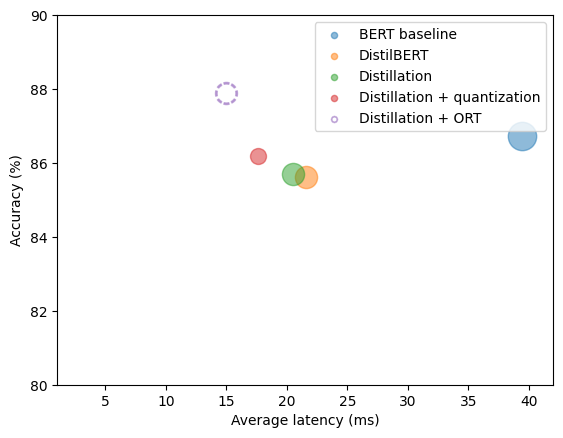

In [88]:
plot_metrics(perf_metrics, optim_type)

In [89]:
# ONNX 모델을 동적 양자화(dynamic quantization)하여 모델의 크기를 줄이고 추론 속도를 향상시키는 작업
from onnxruntime.quantization import quantize_dynamic, QuantType

model_input = "onnx/model.onnx"
model_output = "onnx/model.quant.onnx"
quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8) # 가중치를 8비트 정수로 양자화하도록 지정
# quantize_dynamic : 모델을 동적으로 양자화함

In [90]:
onnx_quantized_model = create_model_for_provider(model_output)
pipe = OnnxPipeline(onnx_quantized_model, tokenizer)
optim_type = "Distillation + ORT (quantized)"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path=model_output)
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 64.36
평균 레이턴시 (ms) - 6.95 +\- 0.52
테스트 세트 정확도 - 0.885


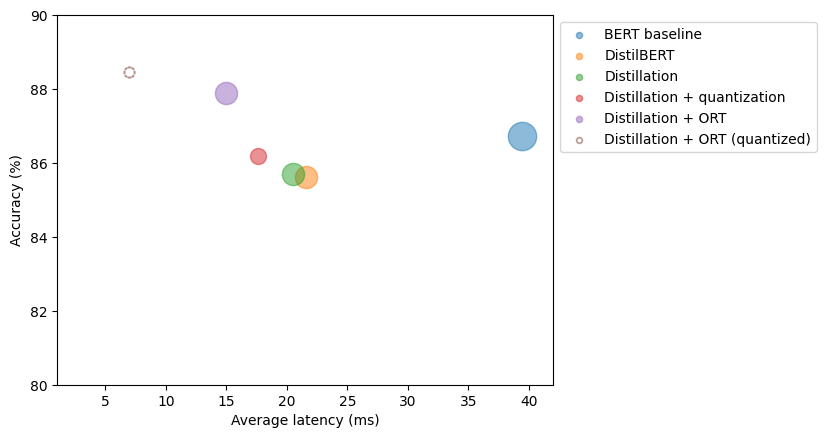

In [91]:
plot_metrics(perf_metrics, optim_type)

## 가중치 가지치기로 희소한 모델 만들기

### 심층 신경망의 희소성

<img alt="Network Pruning" width="500" caption="Weights and neurons before and after pruning (courtesy of Song Han)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_network-pruning.png?raw=1" id="network-pruning"/>

#### Pruning (가지치기)

- 학습된 신경망에서 덜 중요한 연결 또는 뉴런을 제거하여 모델의 크기를 줄이는 기법
- 주로 훈련된 모델을 최적화하는 기법으로 사용됩니다.
- 모델의 크기를 줄이는게 목적이며, 희소성이 높아지는 방향으로 진행됨 
- 학습 후에 모델을 가지치기합니다.

#### Drop-out

- 과적합을 방지하는 정규화 기법입니다.
- 학습 중에 일부 뉴런의 출력을 무작위로 제거함
- 주로 훈련 중에만 사용 (테스트나 추론 시 사용 안함) 
- 모델의 복잡성을 줄이지 않고, 훈련 중에만 사용되기 때문에 모델의 크기를 줄이는 데 사용되지 않음

### 가중치 가지치기 방법

#### 절댓값 가지치기

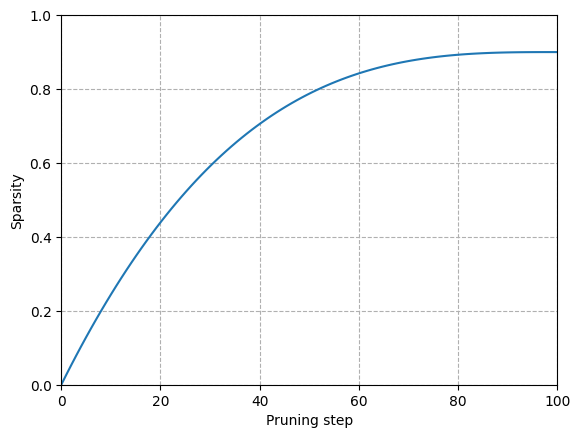

In [92]:
# 가지치기에 사용되는 세제곱 희소성 스케줄러
import numpy as np
import matplotlib.pyplot as plt

def _sparsity(t, t_0=0, dt=1, s_i=0, s_f=0.9, N=100): # 가지치기 단계에 따른 희소성(모델 내의 비활성화된 가중치 비율)을 계산
    # t: 현재 가지치기 단계를 나타내는 변수
    # t_0: 가지치기가 시작되는 단계를 나타내는 변수. 기본값은 0입니다.
    # dt: 가지치기의 전체 기간을 나타내는 변수. 기본값은 1입니다.
    # s_i: 초기 희소성을 나타내는 변수. 기본값은 0입니다.
    # s_f: 최종 희소성을 나타내는 변수. 기본값은 0.9입니다.
    # N: 총 가지치기 단계 수를 나타내는 변수. 기본값은 100입니다.
    return s_f + (s_i - s_f) * (1 - (t - t_0) / (N * dt))**3 # 가지치기 단계가 진행됨에 따라 희소성이 증가하도록 설계
                                                             # 초기 희소성 s_i에서 시작하여 가지치기가 완료될 때 최종 희소성 s_f에 도달하도록 계산됩니다.

steps = np.linspace(0,100,100)
values = [_sparsity(t) for t in steps]

fig, ax = plt.subplots()
ax.plot(steps, values)
ax.set_ylim(0,1)
ax.set_xlim(0,100)
ax.set_xlabel("Pruning step")
ax.set_ylabel("Sparsity")
plt.grid(linestyle="dashed")
plt.show()

#### 이동 가지치기

<img alt="Magnitude vs Movement Pruning" width="700" caption="Comparison of weights removed (in gray) during magnitude pruning (left) and movement pruning (right)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_magnitude-vs-movement.png?raw=1" id="magnitude-vs-movement"/>

<img alt="Pruning Distributions" width="500" caption="Distribution of remaining weights for magnitude pruning (MaP) and movement pruning (MvP)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_pruning-dists.png?raw=1" id="pruning-dists"/>

## 결론